<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Introduction to the DP0.3 Moving Object Catalogs</b> <br>
Contact author: Bob Abel <br>
Last verified to run: 2023-06-27 <br>
LSST Science Piplines version: Weekly 2023_21 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** DP0.3 moving object catalogs are examined.

**Skills:** Discover moving object catalogs and create plots for preliminary analysis. 

**LSST Data Products:** TAP dp03_catalogs.

**Packages:** lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, numpy, matplotlib

**Credit:**
Mario Jurić and literally every single contributing author to the Rubin Stack Club, DP0 Tutorial, and Delegate Contribution, Jupyter Notebooks, and Jake Vanderplas.

**Get Support:**
Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach the user about the basic constituents of the DP0.3 data set.  DP0.3 consists of both real and simulated solar system objects (asteroids, near-earth objects, Trojans, trans-Neptunian objects, and even a simulated spaceship... but no comets, major planets, or the Moon).  It is a hybrid catalog in which objects from the Minor Planet Center have replaced objects with similar properties from the original simulated data set.  

Due to time and effort constraints, only catalog data are available.  Also, since the DP0.2 footprint is far from the ecliptic plane, only a very small fraction of DP0.3 would appear within a DP0.2 visit.  (For those interested, please see notebook **XX** for inserting an DP0.3 object into the appropriate DP0.2 visit calexp image.)

For the real objects in the DP0.3, one should consult the `MPCORB` provided instead of querying the actual the Minor Planet Center (see below).

For additional information, please consult 
<a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>.


### 1.1 Package Imports

Import general python packages and the Rubin TAP service utilities.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd

from lsst.rsp import get_tap_service, retrieve_query

## 2. Create the Rubin SSO TAP Service client

Get an instance of the SSO TAP service, and assert that it exists.

_Note that the DP0.3 TAP service for DP0.3 is "ssotap", **not** "tap" (which is used for DP0.2)._ 

In [19]:
service = get_tap_service("ssotap")
assert service is not None

### 2.1 What are the Moving Object Schemas?

Let's take a look at which schemas are available in DP0.3.### 2.1 What are the Moving Object Schemas?

In [20]:
query = "SELECT * FROM tap_schema.schemas"
results = service.search(query)
print(type(results))

<class 'pyvo.dal.tap.TAPResults'>


In [21]:
results = service.search(query).to_table().to_pandas()
results

,description,schema_index,schema_name,utype
0,Data Preview 0.3 contains the catalog products...,0,dp03_catalogs,
1,A TAP-standard-mandated schema to describe tab...,100000,tap_schema,
2,UWS Metadata,120000,uws,


We see that there is a dp03_catalogs schema.

### 2.2 What are in the DP0.3 catalogs?

In [22]:
schema_names = results['schema_name']
for name in schema_names:
    if name.find('dp03') > -1:
        dp03_schema_name = name
        break
print("DP0.3 schema is " + dp03_schema_name)

DP0.3 schema is dp03_catalogs


In [23]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = '" \
        + dp03_schema_name + "' order by table_index ASC"
print(query)

results = service.search(query)
results = results.to_table()
results

SELECT * FROM tap_schema.tables WHERE tap_schema.tables.schema_name = 'dp03_catalogs' order by table_index ASC


description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
The orbit catalog produced by the Minor Planet Center. Ingested daily. O(10M) rows by survey end. The columns are described at https://minorplanetcenter.net//iau/info/MPOrbitFormat.html,dp03_catalogs,0,dp03_catalogs.MPCORB,table,
"LSST-computed per-object quantities. 1:1 relationship with MPCORB. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSObject,table,
"LSST-computed per-source quantities. 1:1 relationship with DIASource. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSSource,table,
Table to store 'difference image sources'; - sources detected at SNR >=5 on difference images.,dp03_catalogs,0,dp03_catalogs.DiaSource,table,


## 3. What's in the MPCORB catalog and how big is it?

In [24]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.MPCORB")
results.to_table().to_pandas()

,COUNT
0,14600302


There are 14.6M rows. Let's pull out 1% of those, which would be about 43,000 rows. In order to extract data at random, we'll grab a sequence of the ssObjectId's, since they are currently random.

For the moment, we can do this mostly simply by making use of a temporary trick associated with the current version of the prompt processing data products:  the fact that `ssObjectID` is a randomly assigned 64-bit long unsigned integer.  (Note:  since ADQL interprets a 64-bit long unsigned integer as a 63-bit _signed_ integer, these range from a very large negative inte ger value to a very large positive integer value.)  To grab a random sample we grab objects over a small continuous range of values of `ssObjectID`.  

In [25]:
results = service.search("SELECT max(ssObjectId), min(ssObjectId) from dp03_catalogs.MPCORB")

min = int(results[0].get('min'))
max = int(results[0].get('max'))
print('Absolute min, max = ', min, max)
min = int(max - (0.01 * max))
print('1% min, max (from top) = ', min, max)

Absolute min, max =  -9223370383071521539 9223370875126069107
1% min, max (from top) =  9131137166374808576 9223370875126069107


OK, we will grab a random 1% of objects from the `MPCORB` table, making use of the range of `ssObjectID` values we have just found.

(_Note that you'll have some warnings from this next query that aren't your fault and will be corrected in the future._)

In [26]:
query = """SELECT *
FROM dp03_catalogs.MPCORB
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df

,arc,arcEnd,arcStart,computer,e,epoch,flags,fullDesignation,incl,lastIncludedObservation,...,nopp,peri,pertsLong,pertsShort,q,reference,rms,ssObjectId,tperi,uncertaintyParameter
0,NaN,,,,0.570970,54800.000000,0,2011 SR00004K,25.939150,NaN,...,0,350.606980,,,6.113300,,NaN,9185009465900868832,20859.963850,
1,NaN,,,,0.363600,54800.000000,0,2011 SR0000iQ,16.353220,NaN,...,0,147.316050,,,17.303450,,NaN,9136273658435248197,51070.857800,
2,NaN,,,,0.422040,54800.000000,0,2011 SR0000jR,16.453660,NaN,...,0,274.863090,,,6.479600,,NaN,9196671585077870249,28521.104640,
3,NaN,,,,0.639530,54800.000000,0,2011 SR0000sn,15.263050,NaN,...,0,226.268830,,,9.611210,,NaN,9165069355693008015,47926.391840,
4,NaN,,,,0.558600,54800.000000,0,2011 SR0000O9,2.014410,NaN,...,0,342.576070,,,6.387960,,NaN,9204187278771900476,54049.125620,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73194,NaN,,,,0.699330,73349.917495,0,2011 SI00029q,8.924373,NaN,...,0,155.486565,,,1.010904,,NaN,9202444422702896229,72771.929158,
73195,NaN,,,,0.241565,82907.000554,0,2011 SI0002l6,9.715864,NaN,...,0,17.733114,,,0.974737,,NaN,9177118190137388277,83012.719158,
73196,NaN,,,,0.563781,61365.350292,0,2011 SI0002qP,4.110239,NaN,...,0,152.428342,,,0.949081,,NaN,9220586587601309840,61834.429501,
73197,NaN,,,,0.686982,64269.689620,0,2011 SI0002uH,1.053755,NaN,...,0,324.365268,,,0.873964,,NaN,9143316944274961815,65005.664047,


73199 objects have been returned, but 73199 is not 1% of 14600302.

We may have botched something abovec, but let's go with it for now.

Let's look at the column information for the data frame we have just created:

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73199 entries, 0 to 73198
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      0 non-null      float32
 1   arcEnd                   73199 non-null  object 
 2   arcStart                 73199 non-null  object 
 3   computer                 73199 non-null  object 
 4   e                        73199 non-null  float64
 5   epoch                    73199 non-null  float64
 6   flags                    73199 non-null  int32  
 7   fullDesignation          73199 non-null  object 
 8   incl                     73199 non-null  float64
 9   lastIncludedObservation  0 non-null      float32
 10  mpcDesignation           73199 non-null  object 
 11  mpcG                     73199 non-null  float32
 12  mpcH                     73199 non-null  float32
 13  mpcNumber                73199 non-null  int32  
 14  n                     

In [30]:
df.describe()

,arc,e,epoch,flags,incl,lastIncludedObservation,mpcG,mpcH,mpcNumber,n,nobs,node,nopp,peri,q,rms,ssObjectId,tperi
count,0.0,73199.000000,73199.000000,73199.0,73199.000000,0.0,73199.000000,73199.000000,73199.0,0.0,73199.0,73199.000000,73199.0,73199.000000,73199.000000,0.0,7.319900e+04,73199.000000
mean,NaN,0.172110,54802.108562,0.0,10.972516,NaN,0.150000,20.617748,0.0,NaN,0.0,173.933889,0.0,180.749174,2.440718,NaN,9.177219e+18,52907.166256
std,NaN,0.107582,604.821538,0.0,7.747497,NaN,0.000048,2.177858,0.0,NaN,0.0,104.124171,0.0,104.058915,2.278342,NaN,2.656449e+16,4542.692712
min,NaN,-0.002850,54090.500000,0.0,0.000990,NaN,0.150000,4.760000,0.0,NaN,0.0,0.011650,0.0,0.003060,0.011427,NaN,9.131138e+18,-63479.039930
25%,NaN,0.105540,54800.000000,0.0,5.476765,NaN,0.150000,19.610001,0.0,NaN,0.0,83.464248,0.0,90.570235,1.956780,NaN,9.154215e+18,52026.252475
50%,NaN,0.157540,54800.000000,0.0,9.825610,NaN,0.150000,20.900000,0.0,NaN,0.0,167.619030,0.0,181.001910,2.199550,NaN,9.177232e+18,53802.537050
75%,NaN,0.211480,54800.000000,0.0,14.184560,NaN,0.150000,22.040001,0.0,NaN,0.0,264.384020,0.0,271.618820,2.574720,NaN,9.200119e+18,54421.666745
max,NaN,0.999930,90936.183867,0.0,154.846880,NaN,0.150000,26.540001,0.0,NaN,0.0,359.992530,0.0,359.994620,45.345770,NaN,9.223370e+18,112667.605180


Let's drop all the columns that only contain 'NaN' values:

In [31]:
df.dropna(axis=1, how='all', inplace=True)

Let's also drop any columns that contain only one distinct value (e.g., all columns are ' ' or all columns are 0).  We note that `mpcG` is one of the columns that will be dropped, since it was set to 0.15 for all the rows.

In [32]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

Let's see what columns remain.

In [33]:
df.columns

Index(['e', 'epoch', 'fullDesignation', 'incl', 'mpcDesignation', 'mpcH',
       'node', 'peri', 'q', 'ssObjectId', 'tperi'],
      dtype='object')

Let's make some histograms.

Text(0.5, 0.98, 'Some MPCORB Histograms')

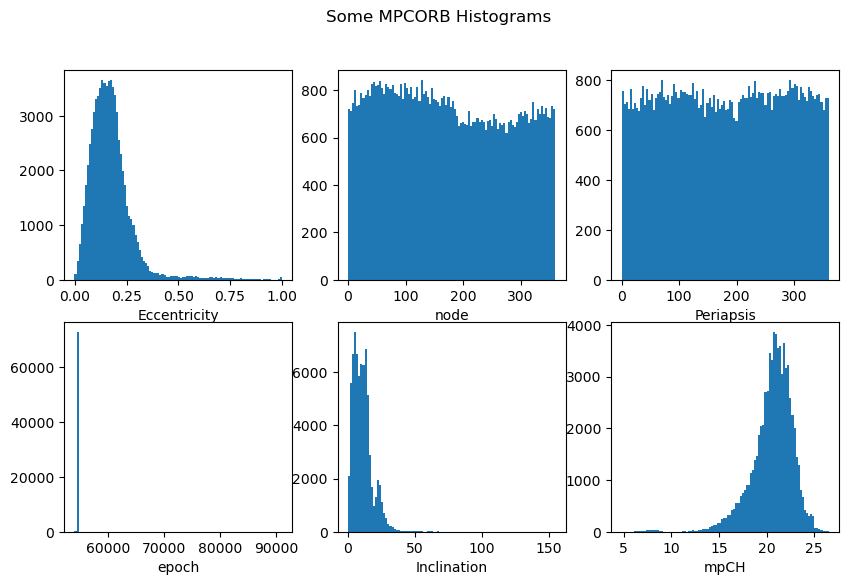

In [34]:
# e, epoch, incl, node, peri, rms

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax[0,0].hist(df['e'], bins=100)
ax[0,0].set_xlabel('Eccentricity')
ax[0,1].hist(df['node'], bins=100)
ax[0,1].set_xlabel('node')
ax[0,2].hist(df['peri'], bins=100)
ax[0,2].set_xlabel('Periapsis')
ax[1,0].hist(df['epoch'], bins=100)
ax[1,0].set_xlabel('epoch')
ax[1,1].hist(df['incl'], bins=100)
ax[1,1].set_xlabel('Inclination')
ax[1,2].hist(df['mpcH'], bins=100)
ax[1,2].set_xlabel('mpCH')
fig.suptitle('Some MPCORB Histograms')


Let's also look at some 2D histograms for eccentricity, nodes, and inclination values.

Text(0.5, 0.98, 'Eccentricity, Node and Inclination')

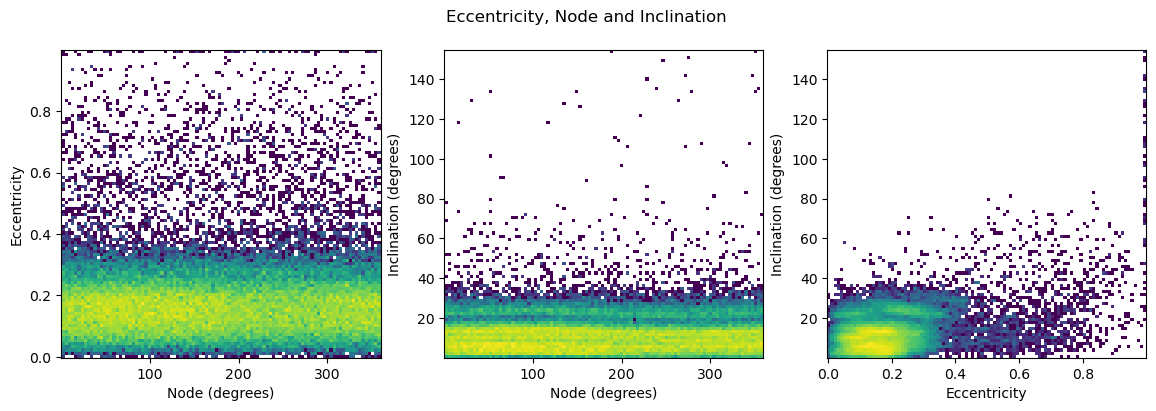

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].hist2d(df['node'], df['e'], bins=100, norm='log')
ax[0].set_xlabel('Node (degrees)')
ax[0].set_ylabel('Eccentricity')
ax[1].hist2d(df['node'], df['incl'], bins=100, norm='log')
ax[1].set_xlabel('Node (degrees)')
ax[1].set_ylabel('Inclination (degrees)')
ax[2].hist2d(df['e'], df['incl'], bins=100, norm='log')
ax[2].set_xlabel('Eccentricity')
ax[2].set_ylabel('Inclination (degrees)')
fig.suptitle("Eccentricity, Node and Inclination")

## 4. What's in the SSObject catalog and how big is it?

Now let's look at the `SSObject` table.

In [50]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSObject")
results.to_table().to_pandas()

,COUNT
0,10222593


As before, we will consider a random set of objects based on their `ssObjectId` values.

In [51]:
query = """SELECT *
FROM dp03_catalogs.ssObject
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
0,3089.883301,60599.295358,60592.295358,0,1.577042,0.338602,0.202955,21.161713,0.019386,0.106775,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,15.927057,61750.270241,61743.270241,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2.961222,62806.302010,62799.302010,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.000000,61654.218500,61647.218500,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3270.825439,60509.383445,60502.383445,0,1.676326,0.051856,0.138421,18.936575,0.018925,0.141764,...,NaN,NaN,0,1.403565,0.171461,0.162144,18.205658,0.016147,0.108125,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51222,1395.834717,60856.431862,60849.431862,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51223,3371.791992,60231.321519,60224.321519,0,4.592573,-0.060991,0.727745,20.432423,0.524340,0.738144,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51224,7.022134,60968.147893,60961.147893,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51225,3071.890625,60495.238170,60488.238170,0,1.098199,0.014991,0.073796,20.547508,0.004406,0.065489,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0


There are 551227 rows.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51227 entries, 0 to 51226
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      51227 non-null  float32
 1   discoverySubmissionDate  51227 non-null  float64
 2   firstObservationDate     51227 non-null  float64
 3   flags                    51227 non-null  int64  
 4   gChi2                    23898 non-null  float32
 5   gG12                     23898 non-null  float32
 6   gG12Err                  23898 non-null  float32
 7   gH                       23898 non-null  float32
 8   gH_gG12_Cov              23898 non-null  float32
 9   gHErr                    23898 non-null  float32
 10  gNdata                   51227 non-null  int32  
 11  iChi2                    25998 non-null  float32
 12  iG12                     25998 non-null  float32
 13  iG12Err                  25998 non-null  float32
 14  iH                    

Let's drop rows that contain any `NaN`'s.

In [53]:
print('Number of rows before dropping all rows with NaNs: %d' %len(df))
df.dropna(inplace=True)
df.reset_index(inplace=True)
print('Number of rows after dropping all rows with NaNs: %d' %len(df))


Number of rows before dropping all rows with NaNs: 51227
Number of rows after dropping all rows with NaNs: 4774


Calculate colors - note that these are all absolute ("H") magnitudes.  (For solar system objects, absolute magnitudes are defined to be for an object 1 A.U. from the Sun and 1 A.U. from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.)

In [54]:
df['ug'] = df['uH'] - df['gH']
df['gr'] = df['gH'] - df['rH']
df['ri'] = df['rH'] - df['iH']
df['iz'] = df['iH'] - df['zH']
df['zy'] = df['zH'] - df['yH']

Let's plot some color-color diagrams for these objects.

Text(0.5, 0.98, 'Color-Color Plots for SSObject Catalog')

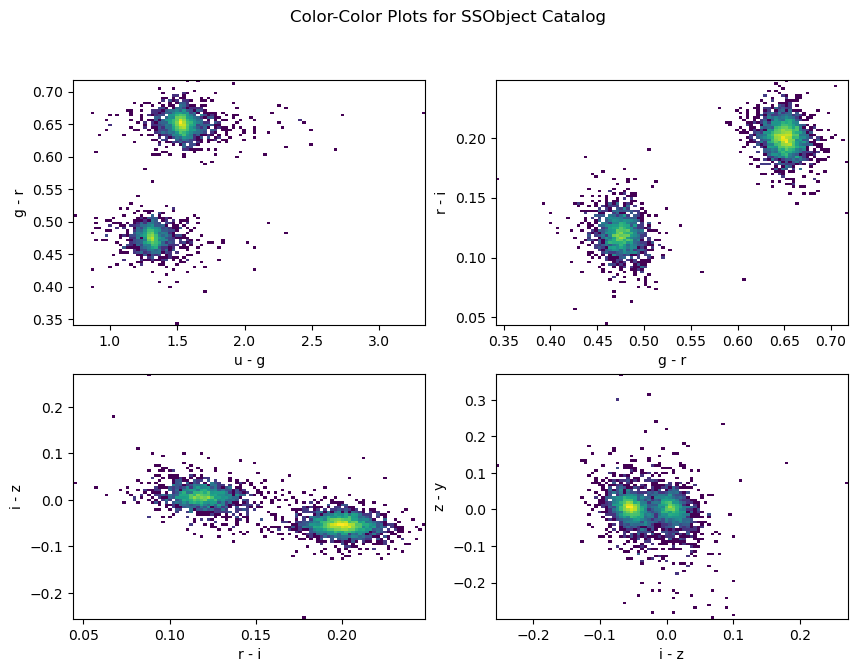

In [55]:
colors = ['ug', 'gr', 'ri', 'iz', 'zy']
filters = ['u', 'g', 'r', 'i', 'z', 'i']
fig, ax = plt.subplots(2, 2, figsize=(10,7))
m = 0
ax[0, 0].hist2d(df['ug'], df['gr'], bins=100, norm='log')
ax[0, 0].set_xlabel('u - g')
ax[0, 0].set_ylabel('g - r')
ax[0, 1].hist2d(df['gr'], df['ri'], bins=100, norm='log')
ax[0, 1].set_xlabel('g - r')
ax[0, 1].set_ylabel('r - i')
ax[1, 0].hist2d(df['ri'], df['iz'], bins=100, norm='log')
ax[1, 0].set_xlabel('r - i')
ax[1, 0].set_ylabel('i - z')
ax[1, 1].hist2d(df['iz'], df['zy'], bins=100, norm='log')
ax[1, 1].set_xlabel('i - z')
ax[1, 1].set_ylabel('z - y')
fig.suptitle('Color-Color Plots for SSObject Catalog')


The fact that we get two such distinct distributions implies that we might not have obtained a truly random distribution of `SSObject`'s.

Now let's look at the estimated statistical error in the g-band absolute magnitude vs. the g-band absolute magnitude.

Text(0.5, 1.0, 'gHErr vs. gH')

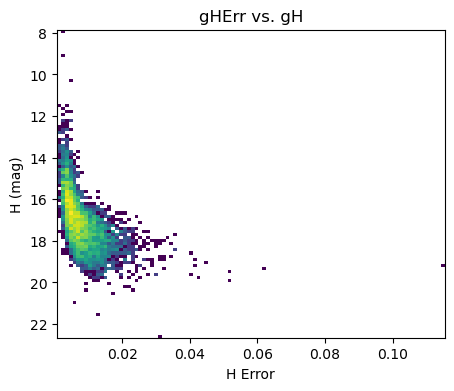

In [58]:
plt.figure(figsize=(5,4))
plt.hist2d(df['gHErr'], df['gH'], bins=100, norm='log')
plt.gca().invert_yaxis()
plt.xlabel('H Error')
plt.ylabel('H (mag)')
plt.title('gHErr vs. gH')

## 5. What's in the SSSource catalog and how big is it?

Now let's look at the `SSSource` table.

In [59]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


**_This table contains over a billion sources!_**

As before, we will consider a random set of objects based on their `ssObjectId` values.

Even so, this next query takes some time (e.g., one typical run lasted 18 minutes)...

In [60]:
query = """SELECT *
FROM dp03_catalogs.SSSource
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,...,residualDec,residualRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ
0,392143802423614332,-3.188224,167.618113,54.929718,254.464829,2.609281,-0.003183,-0.008792,-0.002939,-2.461922,...,NaN,NaN,9131138229541269793,1.653559,0.005932,0.005068,0.002969,-1.612598,0.361386,0.056444
1,-2155482025328203148,-3.187820,167.612385,54.928244,254.455187,2.609279,-0.003182,-0.008792,-0.002939,-2.461998,...,NaN,NaN,9131138229541269793,1.653451,0.005892,0.005073,0.002971,-1.612457,0.361507,0.056515
2,1342595478072641016,-2.451004,160.626934,52.788817,243.109818,2.605045,-0.002056,-0.009109,-0.003037,-2.532769,...,NaN,NaN,9131138229541269793,1.633712,-0.000759,0.006922,0.003820,-1.539799,0.524548,0.151270
3,2072606872722931151,-2.518662,161.128212,52.965287,243.894449,2.605526,-0.002141,-0.009089,-0.003031,-2.528559,...,NaN,NaN,9131138229541269793,1.627975,-0.000228,0.006901,0.003806,-1.538975,0.511110,0.143618
4,8156415499263638424,-2.557995,161.436433,53.073130,244.378345,2.605802,-0.002192,-0.009077,-0.003027,-2.525951,...,NaN,NaN,9131138229541269793,1.625077,0.000347,0.006787,0.003792,-1.538991,0.503040,0.139045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5189995,-4630183780981088497,-19.972689,162.302724,37.371231,255.286230,2.694880,-0.005894,-0.008467,-0.000568,-2.321804,...,NaN,NaN,9223370323280082057,1.817683,0.006701,0.002914,0.004276,-1.627514,0.723433,-0.363064
5189996,1295083018380555837,-20.025738,162.680088,37.437812,255.729750,2.693320,-0.005962,-0.008427,-0.000570,-2.310344,...,NaN,NaN,9223370323280082057,1.829093,0.006955,0.002593,0.004106,-1.640582,0.718544,-0.371166
5189997,-7552594750373973562,-20.025211,162.675287,37.436841,255.724164,2.693339,-0.005961,-0.008428,-0.000570,-2.310490,...,NaN,NaN,9223370323280082057,1.828946,0.006916,0.002598,0.004108,-1.640413,0.718607,-0.371066
5189998,-1597337412419539310,-18.253054,156.410095,36.819809,248.012045,2.713802,-0.005037,-0.008921,-0.000535,-2.453018,...,NaN,NaN,9223370323280082057,1.755972,0.001425,0.006111,0.005880,-1.528258,0.831066,-0.239151


Text(0.5, 1.0, 'heliocentricDist vs. topocentricDist')

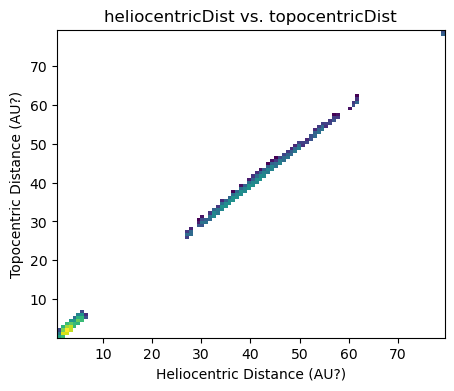

In [61]:
plt.figure(figsize=(5,4))
plt.hist2d(df['heliocentricDist'], df['topocentricDist'], bins=100, norm='log')
plt.xlabel('Heliocentric Distance (AU?)')
plt.ylabel('Topocentric Distance (AU?)')
plt.title('heliocentricDist vs. topocentricDist')

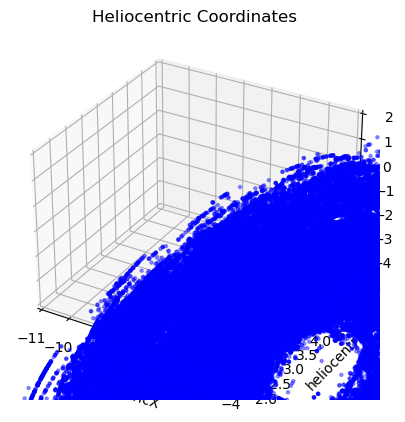

In [62]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['heliocentricX'], df['heliocentricY'], df['heliocentricZ'], c='blue', marker='.')

ax.set_xlabel('heliocentricX')
ax.set_ylabel('heliocentricY')
ax.set_zlabel('heliocentricZ')
ax.set_xlim(-11, -4)
ax.set_ylim(2, 6)
ax.set_zlim(-4, 2)
ax.set_title("Heliocentric Coordinates")
plt.show()


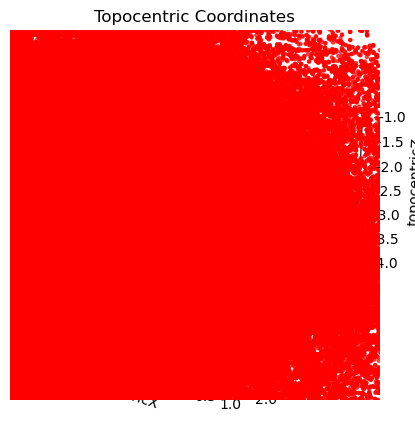

In [63]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['topocentricX'], df['topocentricY'], df['topocentricZ'], c='red', marker='.')

ax.set_xlabel('topocentricX')
ax.set_ylabel('topocentricY')
ax.set_zlabel('topocentricZ')
ax.set_xlim(-3, 1)
ax.set_ylim(2, 6)
ax.set_zlim(-4, -1)
ax.set_title("Topocentric Coordinates")
plt.show()


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190000 entries, 0 to 5189999
Data columns (total 29 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   diaSourceId              int64  
 1   eclipticBeta             float64
 2   eclipticLambda           float64
 3   galacticB                float64
 4   galacticL                float64
 5   heliocentricDist         float32
 6   heliocentricVX           float32
 7   heliocentricVY           float32
 8   heliocentricVZ           float32
 9   heliocentricX            float32
 10  heliocentricY            float32
 11  heliocentricZ            float32
 12  mpcUniqueId              int64  
 13  phaseAngle               float32
 14  predictedDecSigma        float32
 15  predictedMagnitude       float32
 16  predictedMagnitudeSigma  float32
 17  predictedRaDecCov        float32
 18  predictedRaSigma         float32
 19  residualDec              float64
 20  residualRa               float64
 21  ssObject

Text(0, 0.5, 'Ecliptic β (deg)')

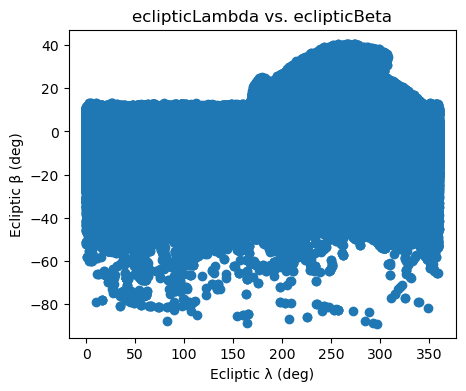

In [65]:
plt.figure(figsize=(5,4))
plt.scatter(df['eclipticLambda'], df['eclipticBeta'])
plt.title('eclipticLambda vs. eclipticBeta')
plt.xlabel('Ecliptic λ (deg)')
plt.ylabel('Ecliptic β (deg)')

Text(0, 0.5, 'Galactic Latitude (deg)')

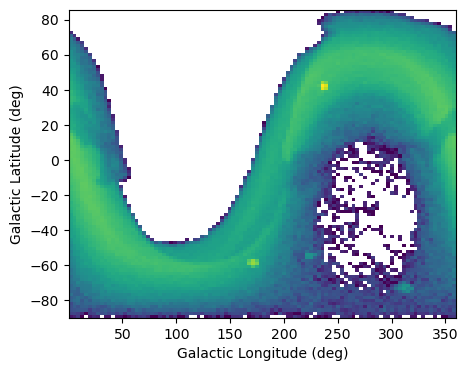

In [66]:
plt.figure(figsize=(5,4))
plt.hist2d(df['galacticL'], df['galacticB'], bins=100, norm='log')
plt.xlabel('Galactic Longitude (deg)')
plt.ylabel('Galactic Latitude (deg)')

## 6. What's in the DiaSource catalog and how big is it?


In [67]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.DiaSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


In [ ]:
query = """SELECT *
FROM dp03_catalogs.DiaSource
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df

In [ ]:
df.info()

It seems like the true values of ra and dec nearly agree. Does mag add an error function to _magTrue?

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].scatter(df['_raTrue'], df['ra'])
ax[0].set_xlabel('_raTrue')
ax[0].set_ylabel('ra')
ax[0].set_title('_raTrue vs. ra')

ax[1].scatter(df['_decTrue'], df['decl'])
ax[1].set_xlabel('_decTrue')
ax[1].set_ylabel('decl')
ax[1].set_title('_decTrue vs. decl')

ax[2].scatter(df['_magTrue'], df['mag'])
ax[2].set_xlabel('_magTrue')
ax[2].set_ylabel('mag')
ax[2].set_title('_magTrue vs. mag')
ax[2].invert_xaxis()
ax[2].invert_yaxis()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].scatter(df['_raTrue'], df['ra'] - df['_raTrue'])
ax[0].set_xlabel('_raTrue')
ax[0].set_ylabel('ra - ra_True')
ax[0].set_title('_raTrue vs. ra')

ax[1].scatter(df['_decTrue'], df['decl'] - df['_decTrue'])
ax[1].set_xlabel('_decTrue')
ax[1].set_ylabel('decl - _decTrue')
ax[1].set_title('_decTrue vs. decl - _decTrue')

ax[2].scatter(df['_magTrue'], df['mag'] - df['_magTrue'])
ax[2].set_xlabel('_magTrue')
ax[2].set_ylabel('mag - _magTrue')
ax[2].set_title('_magTrue vs. mag - _magTrue')
ax[2].invert_xaxis()
ax[2].invert_yaxis()

In [ ]:
plt.scatter(df['snr'], (df['mag']))
plt.gca().invert_yaxis()
plt.xlabel('Signal-to-Noise Ratio ("snr")')
plt.ylabel('magnitude ("mag")')
plt.title('Why do lower magnitudes have higher SNR? (All filters here)')

Try separating the filters into separate tables.

In [ ]:
filter_label = ['u', 'g', 'r', 'i', 'z', 'y']
df_u = df[(df['filter'] == 'u')] 
df_g = df[(df['filter'] == 'g')]
df_r = df[(df['filter'] == 'r')]
df_i = df[(df['filter'] == 'i')]
df_z = df[(df['filter'] == 'z')] 
df_y = df[(df['filter'] == 'y')] 

In [ ]:
plot_color = ['violet', 'blue', 'green', 'yellow', 'orange', 'red'] 
fig, ax, = plt.subplots(2, 3, figsize=(10,6))
m = 0
ax[0,0].scatter(df_u['snr'], df_u['mag'], color = plot_color[0], label='u')
ax[0,1].scatter(df_g['snr'], df_g['mag'], color = plot_color[1], label='g')
ax[0,2].scatter(df_r['snr'], df_r['mag'], color = plot_color[2], label='r')
ax[1,0].scatter(df_i['snr'], df_i['mag'], color = plot_color[3], label='i')
ax[1,1].scatter(df_z['snr'], df_z['mag'], color = plot_color[4], label='z')
ax[1,2].scatter(df_y['snr'], df_y['mag'], color = plot_color[5], label='y')
fig.suptitle('SNR vs. apparent magnitude for all filters')
for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('SNR')
        ax[i,j].set_ylabel(filter_label[m] + '_mag')
        ax[i,j].invert_yaxis()
        ax[i,j].legend()
        m += 1

In [ ]:
fig, ax, = plt.subplots(2, 3, figsize=(10,6))

ax[0,0].scatter(np.log10(df_u['snr']), df_u['magSigma'], color = plot_color[0], label='u')
ax[0,1].scatter(np.log10(df_g['snr']), df_g['magSigma'], color = plot_color[1], label='g')
ax[0,2].scatter(np.log10(df_r['snr']), df_r['magSigma'], color = plot_color[2], label='r')
ax[1,0].scatter(np.log10(df_i['snr']), df_i['magSigma'], color = plot_color[3], label='i')
ax[1,1].scatter(np.log10(df_z['snr']), df_z['magSigma'], color = plot_color[4], label='z')
ax[1,2].scatter(np.log10(df_y['snr']), df_y['magSigma'], color = plot_color[5], label='y')
fig.suptitle('$Log_{10}$(SNR) vs. ${\sigma}_{m}$ for all filters')
for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('log(SNR)')
        ax[i,j].set_ylabel('${\sigma}_{m}$')
        
        ax[i,j].legend()


The `magnitude` column encompasses all colors (there's a separate `filter` column) and, as shown below, the number of observations varies for each filter. I think color calculations would focus on ssObjectId. How do we calculate colors for objects? How many observations in how many filters? </span>

In [ ]:
print("There are %d unique ssObjectId's out of %d objects" %(len(np.unique(df['ssObjectId'])), len(df)))


In [ ]:
df = df.sort_values(by=['ssObjectId'])
df = df.reset_index()

In [ ]:
for i in range(37,56):
    print(i, df['ssObjectId'][i], df['mag'][i], df['midPointTai'][i]-60000.)

`ssObjectId` is the moving object identifier, but how should we calculate colors?

In [ ]:
print('# of Entries for each filter:')
print(' u   g   r    i   z   y')
print(len(df_u), len(df_g), len(df_r), len(df_i), len(df_z), len(df_y))